In [1]:
# count frequency models won't give you the relation between a word and it's neighbors
# we use word-embedding can recognize the relationship between cats and dogs. because they are animals.  

In [4]:
#used tutorial from tensorflow
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

In [5]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

In [6]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [7]:
words = fetch_words_data()

In [16]:
len(words)

17005207

In [19]:
from collections import Counter

In [32]:
def create_Counts(vocab_size = 50000):
    vocab =  [] + Counter(words).most_common(vocab_size)
    vocab = np.array([word for word, _ in vocab])
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab

In [33]:
data, vocabulary = create_Counts(50000)

In [34]:
data.shape

(17005207,)

In [35]:
vocabulary.shape

(50000,)

In [36]:
words[100]

'interpretations'

In [37]:
data[100] #interpretations is associated eith the number 4198

4198

In [38]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [39]:
#constants
batch_size = 128
embedding_size =150  #dimensions that the word vector have, more dimenesion = more information but more time req
skip_window = 1 #how many words to consider to the left and right
num_skips = 2 #how many time we use inputs to generate label

In [41]:
test_size = 16
test_window = 100
test_examples = np.random.choice(test_window, test_size, replace = False)

In [42]:
test_examples

array([30,  2, 29, 52, 81, 89, 63, 88,  9, 31, 46, 13, 19, 18, 23, 24])

In [53]:
num_sampled = 64
lr = 0.01
vocabulary_size = 50000

In [54]:
tf.reset_default_graph()

In [55]:
train_inputs = tf.placeholder(tf.int32, shape = [None])

In [56]:
train_labels = tf.placeholder(tf.int32, shape = [batch_size,1])

In [57]:
test_dataset = tf.constant(test_examples, dtype = tf.int32)

In [58]:
# Look up embeddings for inputs.
#50000 words and 150 dimensions for each word.

init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [59]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [60]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [61]:
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

In [62]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [67]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
test_embeddings = tf.nn.embedding_lookup(normalized_embeddings, test_dataset)
similarity = tf.matmul(test_embeddings, normalized_embeddings, transpose_b=True)

In [72]:
data_index = 0

In [73]:
# Add variable initializer.
init = tf.global_variables_initializer()

In [74]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [76]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
num_steps = 5000 #20000 gives optimal

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  258.8352966308594
Average loss at step  1000 :  9719.236696289063
Average loss at step  2000 :  19999.23043874359
Average loss at step  3000 :  29020.05600137329
Average loss at step  4000 :  32128.144352645875


In [77]:
# T-distributed stochastic neighbour embedding to visualize this 

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [80]:
type(final_embeddings)

numpy.ndarray

In [81]:
final_embeddings.shape

(50000, 150)

In [82]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [84]:
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [85]:
labels = [vocabulary[i] for i in range(plot_only)]

In [86]:
low_dim_embs.shape

(500, 2)

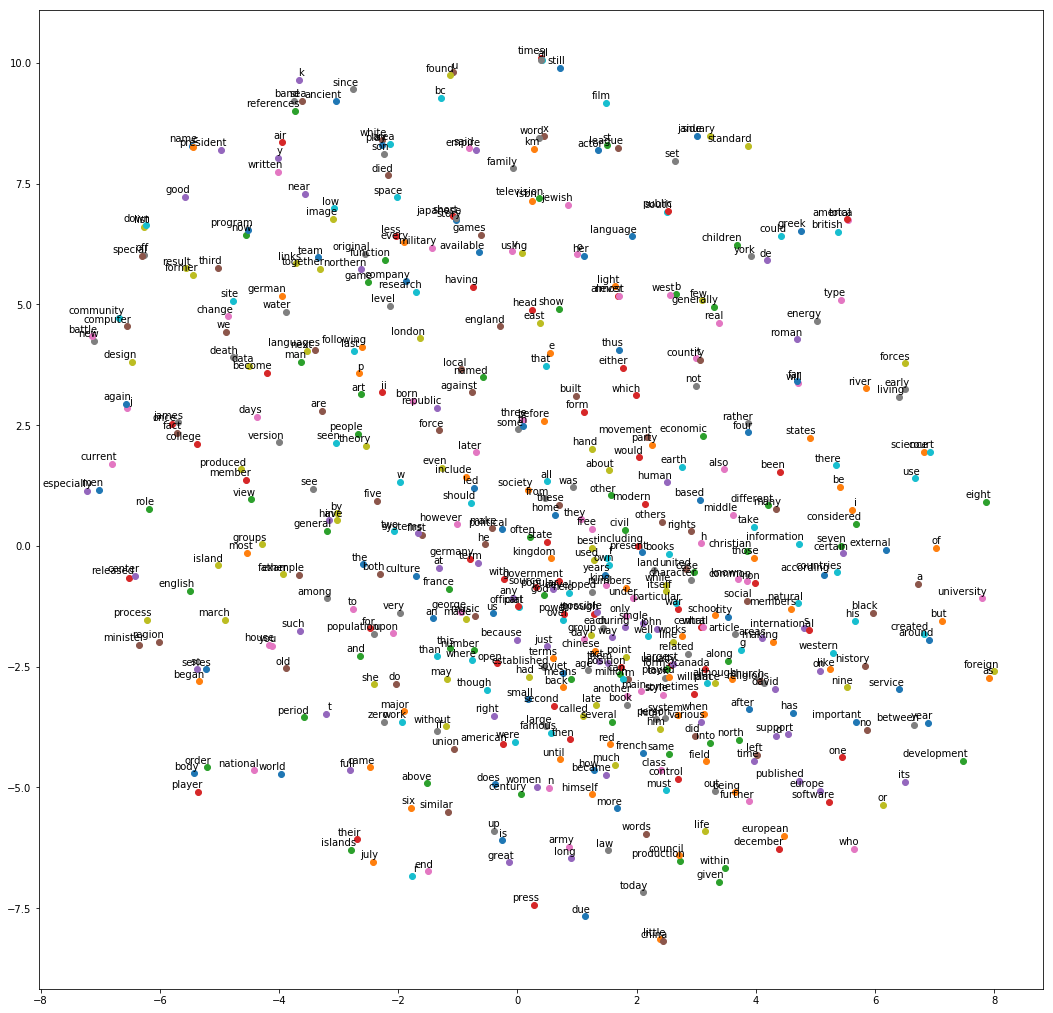

In [87]:
plot_with_labels(low_dim_embs, labels)

(-10, 10)

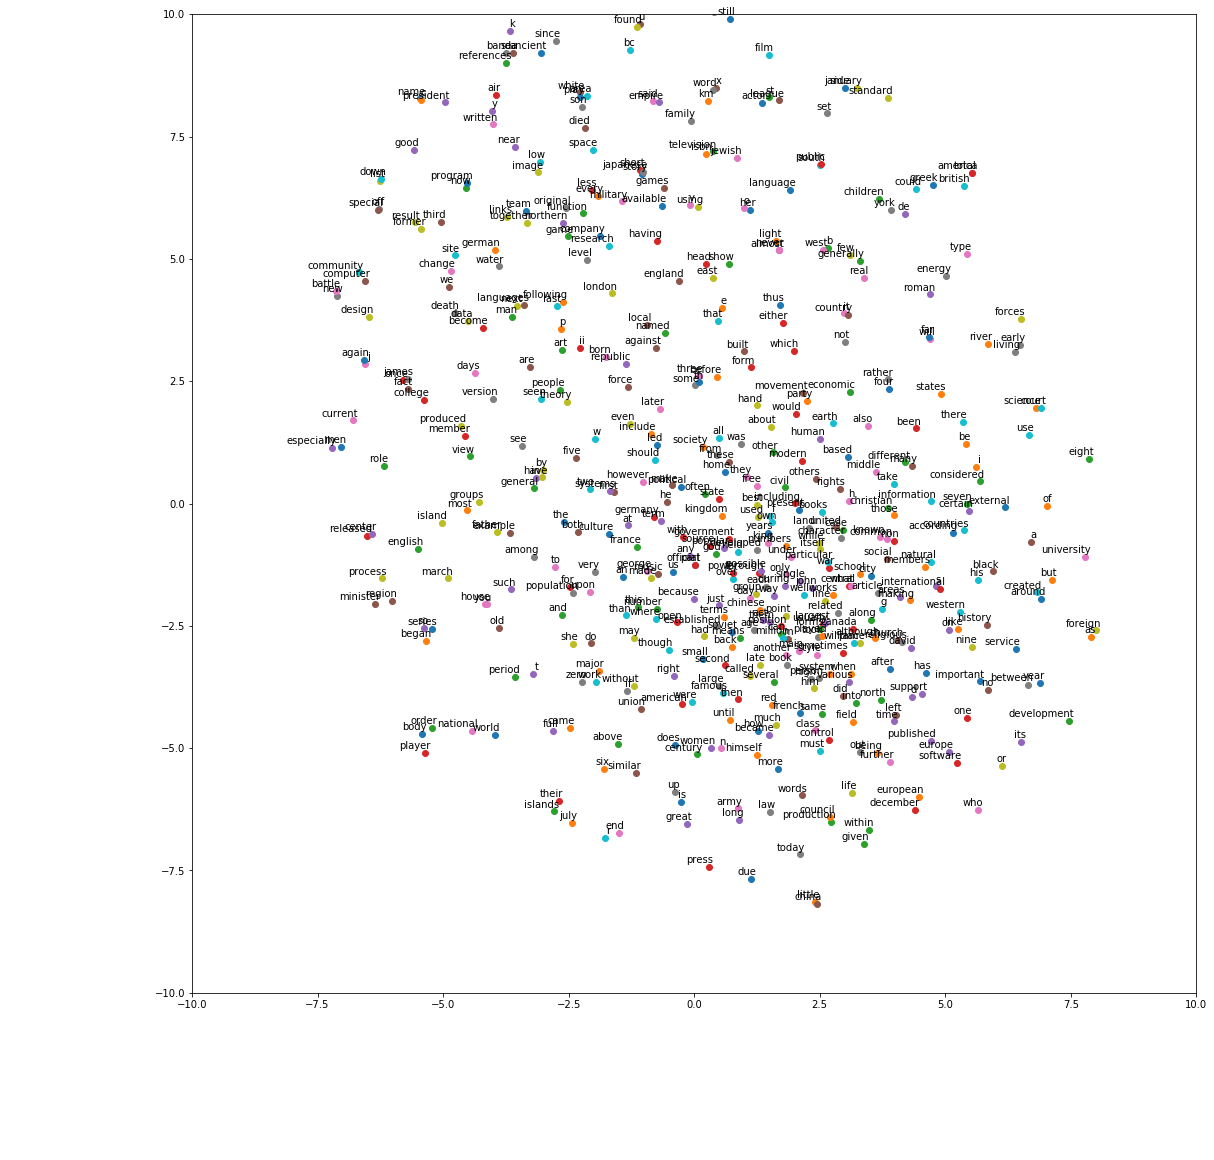

In [88]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-1np.save('trained_embeddings_200k_steps',final_embeddings)0,10)

In [103]:
np.save('trained_embeddings_5k_steps',final_embeddings)

In [101]:
final_embeddings_200 = np.load("trained_embeddings_200k_steps.npy") #this a saved model trained over 200k time
#load it and plot to see the words.